<a class="anchor" id="22"></a>
# [Outlines](#22)

* [0. Introduction](#0)
* [1.Importing Packages and Collecting Data](#1)
* [2.Problem Description and Objective](#2)
* [3.Variable Description and Identification](#3)
* [4.Feature engineering](#4)
* [5.Balance issue on the data](#5)
* [6.Pre-processing](#6)
* [7.Handling with imbalanced data with "imblearn" library](#7)
    * [7.1 Over sampling methods](#7.1)
        * [7.1.1 Naive Random Over Sampler](#7.1.1)
        * [7.1.2 SMOTE *(Synthetic Minority Over-sampling Technique) Method*](#7.1.2)    
            * [7.1.2.1 SMOTE Variants](#7.1.2.1)
        * [7.1.3 ADASYN *(Adaptive Synthetic)*](#7.1.3)
    * [7.2 Under Sampling Methods](#7.2)
        * [7.2.1 Under Sampling with Tomek Link](#7.2.1)
        * [7.2.2 Edited Nearest Neighbours](#7.2.2)
    * [7.3 Combined Re-sampling method](#7.3)
        * * [7.3.1 SMOTE Tomek](#7.3.1)
* [8. Model Building and Evaluation](#8)
    * [8.1 Hyper optimisation with Randomised Search Algorithm](#8.1)   
    * [8.2 Hyper optimisation based Grid Search with OPTUNA](#8.2)
        * [8.2.1 Raw data with optimised paramters](#8.2.1)
        * [8.2.2 Balanced data set with SMOTE-Tomek](#8.2.2)
* [9. Feautere importance explaining with SHAP library](#9)
* [10. Feature Selection with RFECV algorithm](#10)
* [11. Final Model](#11)
* [12. Principal Component Analysis](#12)
* [13. Model Building with Feature Engineering Data](#13)
* [14. Result](#14)
* [15. ROC Analysis](#15)
* [16. Conclusion](#16)




# <a class="anchor" id="0"></a>**Introduction**
[Back to Index](#22)

Of all the applications of artificial intelligence, diagnosing any disease using a "black box" is always going to be a hard explanation. Those who will use the application will want to know how the model decides on the treatment conditions or following-up conditions according to the model result. Or data provider clinicians will want the model with the highest performance in their project. This dataset classified patients according to sacral position properties. I investigated using the below techniques for the best result and explainable machine learning model;

- Balancing unbalanced medical data
- Creating models with CatBoost Classifier
- Finding the most optimized parameters by Grid Search with the Optuna library
- Artificial intelligence algorithms described as Black Box are actually explainable
- SHAP library tutorial
- Combined use of RFECV and SHAP library for Feature Selection
- Comparison of all applied models to each other

# <a class="anchor" id="1"></a>**1.Importing Packages and Collecting Data**
[Back to Index](#22)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/biomechanical-features-of-orthopedic-patients/column_3C_weka.csv
/kaggle/input/biomechanical-features-of-orthopedic-patients/column_2C_weka.csv


In [2]:
# İmporting to libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import os
import random
import warnings
warnings.filterwarnings('ignore')
# I used the CatBoost algorithm with this imbalanced dataset. CatBoost algorithm has high performance for imbalanced datasets.
!pip install catboost
import seaborn as sns

In [3]:
# Let's to import dataset
data = pd.read_csv("../input/biomechanical-features-of-orthopedic-patients/column_2C_weka.csv")
data.head(5)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


# <a class="anchor" id="2"></a>**2.Problem Description and Objective**
[Back to Index](#22)

## In this study, patients will be classified according to their biomechanical data.

The data were organized for the classification task in two different ways.

First: column_3C_weka.csv (file with three class labels):

Second: column_2C_weka.csv (file with two class labels): *We use this dataset*




For the second mission, "Disc Hernia" and "Spondylolisthesis" categories were combined into one category, labeled "abnormal". Thus, patients were labeled with a class belonging to one of the two categories; Normal (100 normal) or Abnormal (210 patients). It results in 210/310 = 0.68, which creates a serious tending to disease bias for machine learning algorithms.However, medical data often consists of imbalanced data. Because it should be spread with normal distribution in accordance with the central limit theorem rather than a Bernoulli distribution in the world, which creates an imbalance in the targets. Often, in disease data, the diseased population is nadir than the healthy population, but in this data, the diseased population represents a larger population. This imbalance may create a bias towards the disease.





# <a class="anchor" id="3"></a>**3.Variable Description and Identification (EDA)**
[Back to Index](#22)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


#### Well know question is is there any 'NaN value' and length of this data so lets look at info

As you can see:
* length: 310 (range index)
* Features are float
* Target variables are object 
* Okey we have some ideas about data but lets look go inside data deeper

# <a class="anchor" id="4"></a>**4.Feature engineering**
[Back to Index](#22)

There are 5 different features and 310 samples in the data set. All variables consist of numerical values, there are no categorical variables (just target class).

Features:
* 'pelvic_incidence':  angle between the perpendicular of the upper endplate of S1 and the linejoining the middle of the upper endplate of S1and the hip axis (midway between the centers ofthe two femoral heads).
* 'pelvic_tilt numeric': angle between the vertical lineand the line joining the middle of the upperendplate of S1 and the hip axis (positive when thehip axis lies in front of the middle of the upperendplate of S1) 
* 'lumbar_lordosis_angle': (b) normal lordosis (NL) is in the 31–50° range, (a) excessive lordosis (EL) is over 70°, (d) lumbar kyphosis (LK) is less than 10°, (c) and hypo-lordosis (HL) is in the 11–30° range to create the musculoskeletal model of lumbar lordosis for each case. [reference](https://ieeexplore.ieee.org/abstract/document/102791?casa_token=jbH9kBG6OhQAAAAA:u41imXpZy1CRUv87LHqFeMVNuHBgOxjEI1LqknA0lg47uNDF2kE-0_nlY5qcuOncShWTPdaT2A)
* 'sacral_slope': angle between the upper end plate of S1 and the horizontal line.
* 'pelvic_radius'
* 'degree_spondylolisthesis'



![Classification with lumbar lordosis angle](https://ars.els-cdn.com/content/image/1-s2.0-S0268003310001026-gr4.jpg)

In [5]:
result_of_lordosis = []
for i in range(len(data.lumbar_lordosis_angle)):
    a = data.lumbar_lordosis_angle[i]
    if a <= 50 and a>=31:
        result_of_lordosis.append("normal_lordosis")
    elif a>70:
        result_of_lordosis.append("excessive_lordosis")
    elif a<10:
        result_of_lordosis.append("lumbar_kyphosis")
    else:
        result_of_lordosis.append("hypo_lordosis")

categoric_lordosis_data = data.copy()        
categoric_lordosis_data["result_of_lordosis"] = result_of_lordosis
categoric_lordosis_data = categoric_lordosis_data.drop(columns=["lumbar_lordosis_angle"])
categoric_lordosis_data = categoric_lordosis_data[['pelvic_incidence', 'pelvic_tilt numeric', 
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'result_of_lordosis','class']]
data.lumbar_lordosis_angle.describe() 

count    310.000000
mean      51.930930
std       18.554064
min       14.000000
25%       37.000000
50%       49.562398
75%       63.000000
max      125.742385
Name: lumbar_lordosis_angle, dtype: float64

In [6]:
categoric_lordosis_data.head(3)

,pelvic_incidence,pelvic_tilt numeric,sacral_slope,pelvic_radius,degree_spondylolisthesis,result_of_lordosis,class
0,63.027817,22.552586,40.475232,98.672917,-0.254400,normal_lordosis,Abnormal
1,39.056951,10.060991,28.995960,114.405425,4.564259,hypo_lordosis,Abnormal
2,68.832021,22.218482,46.613539,105.985135,-3.530317,hypo_lordosis,Abnormal


I don't expect for the kyphosis class, because of min lumbar lordosis angle is 14.

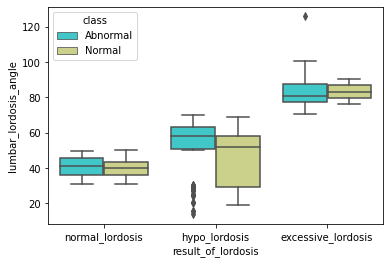

In [7]:
sns.boxplot(x=categoric_lordosis_data["result_of_lordosis"],y=data.lumbar_lordosis_angle,hue=data["class"],palette="rainbow")
plt.show()

I think the type of lordosis doesn't affect hugely.

<AxesSubplot:xlabel='pelvic_incidence'>

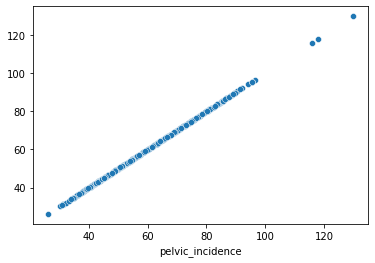

In [8]:
# Pelvic incidence = (data["pelvic_incidence"] = (data["pelvic_tilt numeric"]+data["sacral_slope"]) (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2527424/pdf/586_2008_Article_713.pdf)
sns.scatterplot(x=data["pelvic_incidence"],y=(data["pelvic_tilt numeric"]+data["sacral_slope"]))

Formula is correct!!

![pelvic_incidence](https://www.researchgate.net/profile/Jean-Charles-Lehuec/publication/265395255/figure/fig1/AS:501816921792512@1496653885506/Pelvic-parameters-PT-pelvic-tilt-SS-sacral-slope-PI-pelvic-incidence_W640.jpg)

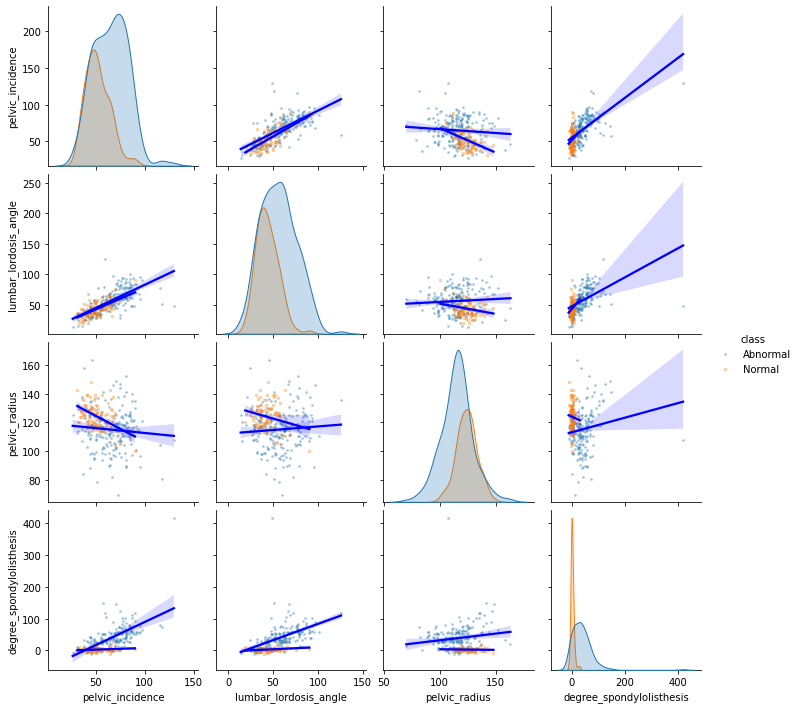

In [9]:
# pelvic incidence = pelvic slope + pelvic tilt, we can drop these for pair plot
dropped_pelvic_tilt_and_pelvic_slope_data = data.drop(columns=["sacral_slope","pelvic_tilt numeric"])
g = sns.pairplot(dropped_pelvic_tilt_and_pelvic_slope_data, hue="class", markers=["o", "s"], kind='reg',plot_kws={'line_kws':{'color':"blue"}, 'scatter_kws': {'alpha': 0.3,"s":3}})
plt.show()

We can see a high correlation between pelvic_incidence pelvic_tilt numeric, lumbar_lordosis_angle, and sacral_slope. This correlation with pelvic_radius and degree_spondylolisthesis is important in target class differentiation.
The pelvic_radius and pelvic_tilt numeric data are the same. In fact, here the pelvic_radius feature can be visually selected as the most distinguishing feature.

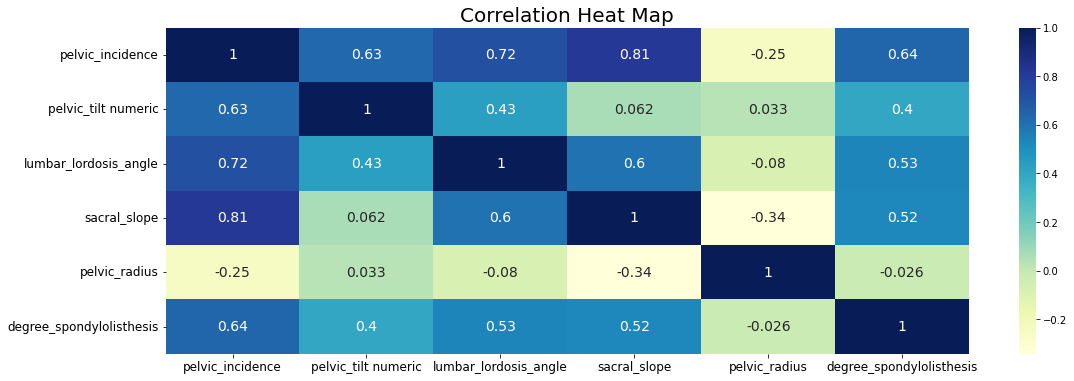

In [10]:
# Now create the correlation heatmap
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
sns.heatmap(data.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Correlation Heat Map", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 12)
ax.tick_params(axis = "both", which = "minor", labelsize = 10)
plt.show()

Pelvic slope and pelvic tilt doenst have good correlation.

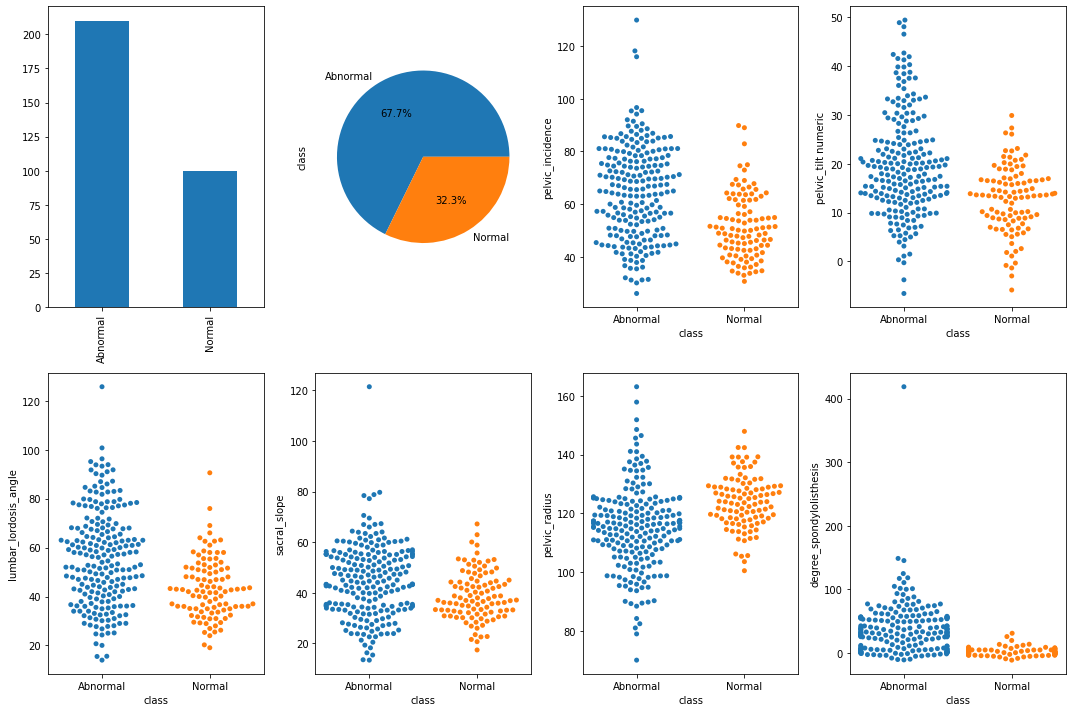

In [11]:
def plot_categorical(dataset, categorical_feature, rows, cols):
    fig, axarr=plt.subplots(nrows=2,ncols=4, figsize=(15,10))
    features=dataset.columns.values[:-1]
    
    counter=0
    #sns.countplot(x=categorical_feature, data=dataset, ax=axarr[0,0])
    dataset['class'].value_counts().plot.bar(ax=axarr[0,0])
    dataset['class'].value_counts().plot.pie(autopct="%1.1f%%",ax=axarr[0,1])
    for i in range(rows):
        for j in range(cols):
            feature=features[counter]
            if (i==0 and j==0) or (i==0 and j==1):
                continue
            else:
                sns.swarmplot(x=categorical_feature,y=feature,
                             
                            data=dataset, 
                            ax=axarr[i, j])
            counter=counter+1
            if counter>=len(features):
                break
    
    plt.tight_layout()
    plt.show()

    
plot_categorical(dataset=data, categorical_feature="class", rows=2, cols=4)

# https://www.kaggle.com/code/serkanpeldek/alt-zelli-e-g-re-hastalar-n-s-n-fland-r-lmas

# <a class="anchor" id="5"></a>**5.Balance issue on the data**
[Back to Index](#22)

### What are Balanced and Imbalanced Datasets?
#### Balanced Dataset:

Let’s take a simple example if in our data set we have positive values which are approximately same as negative values. Then we can say our dataset in balance



![Balanced Data](https://miro.medium.com/max/258/1*EZxsI_kDPlZFPPYEG17ZQg.png)


Consider Orange color as a positive values and Blue color as a Negative value. We can say that the number of positive values and negative values in approximately same.

### Imbalanced Dataset:

If there is the very high different between the positive values and negative values. Then we can say our dataset in Imbalance Dataset.


![Imbalance Dataset](https://miro.medium.com/max/518/1*xgdJE0zazGdn15NZinqepA.png)



In this dataset targets are class 1 for patient and class 0 for normal people. We can see in this plot, class 1 is two fold of class 0.

[What Is Balanced And Imbalanced Dataset?](https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5)

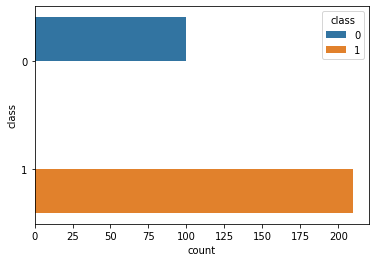

<Figure size 432x288 with 0 Axes>

In [12]:
data["class"] = [1 if each == "Abnormal" else 0 for each in data["class"]]

sns.countplot(y=data["class"],hue=data["class"])
plt.figure()
plt.show()

# <a class="anchor" id="6"></a>**6.Pre-processing**
[Back to Index](#22)

In [13]:
y = data["class"].values # class feature is y
X = data.drop(["class"],axis=1) 

In [14]:
# Normalisation to data
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
columns_df = X.columns
scaled_X = pd.DataFrame(data_scaled, columns = columns_df)
X = scaled_X
X.head(3)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,0.147086,0.501369,-0.665177,-0.184950,-1.447647,-0.708059
1,-1.245864,-0.748769,-1.453001,-1.041521,-0.264385,-0.579556
2,0.484370,0.467932,-0.099262,0.273083,-0.897686,-0.795421


In [15]:
#If we are over-sampling or under-sampling all the data, we must first split to train and test data for protecting from data leakage.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

# <a class="anchor" id="7"></a>**7.Handling with imbalanced data with "imblearn" library**
[Back to Index](#22)

# imblearn library
imbalanced-learn (imported as imblearn) is an open source and very useful library. This library is MIT-licensed library relying on scikit-learn (imported as sklearn) and provides tools when dealing with classification with imbalanced classes.
I use modules from imblearn library for examples.

In [16]:
from imblearn.over_sampling import RandomOverSampler,ADASYN,BorderlineSMOTE,SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks 
from imblearn.combine import SMOTEENN,SMOTETomek

## <a class="anchor" id="7.1"></a>**7.1 Over sampling methods**
[Back to Index](#22)

### <a class="anchor" id="7.1.1"></a>**7.1.1 Naive Random Over Sampler**

One way to fight this issue is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples. The RandomOverSampler offers such scheme:



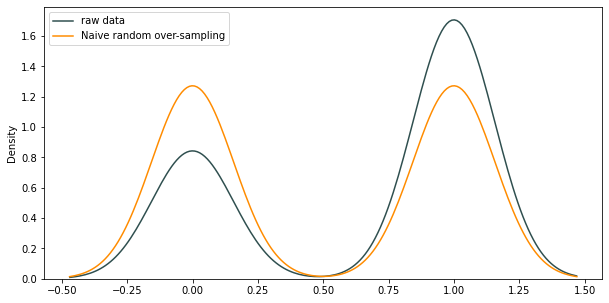

In [17]:
ros = RandomOverSampler(random_state=42)
X_resampled_naive, y_resampled_naive = ros.fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_resampled_naive, label="Naive random over-sampling",color="darkorange")
plt.legend()
plt.show()

In [18]:
pd.concat([X.describe(),X_resampled_naive.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,-0.179361,-0.167643,-0.137510,-0.105321,0.109702,-0.169916
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,0.955187,0.901395,0.903771,0.945608,0.894792,0.921709
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.996010,-2.411664,-2.047652,-2.196576,-3.597963,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.926923,-0.758975,-0.823825,-0.753187,-0.365129,-0.685295
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,-0.369246,-0.298241,-0.271532,-0.139910,0.109579,-0.533118
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.486881,0.269435,0.400963,0.508140,0.596124,0.118761
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,3.138539,2.635121,5.855771,3.395818,10.460350


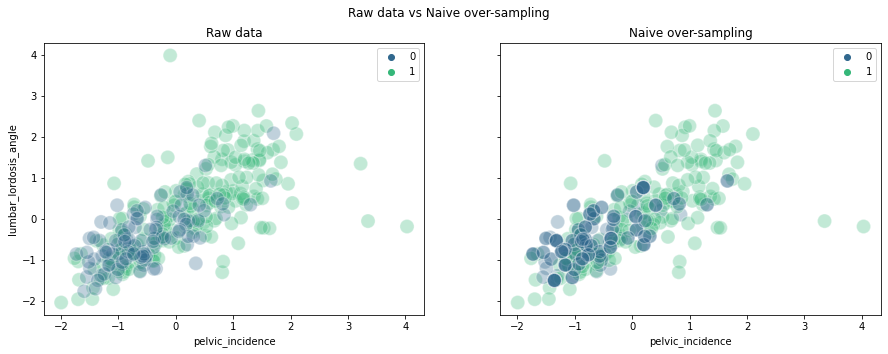

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs Naive over-sampling')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")


# oversampled data
sns.scatterplot(x=X_resampled_naive.pelvic_incidence,y=X_resampled_naive.lumbar_lordosis_angle,hue=y_resampled_naive,palette="viridis",s=200,alpha=.3)
axes[1].set_title("Naive over-sampling")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

some plots were overlapped.

### <a class="anchor" id="7.1.2"></a>**7.1.2 SMOTE *(Synthetic Minority Over-sampling Technique) Method***

One popular method to dealing with this problem is oversampling using SMOTE. Imbalanced learn is a python library that provides many different methods for classification tasks with imbalanced classes. One of the popular oversampling methods is SMOTE.

SMOTE stands for Synthetic Minority Over-sampling Technique. Given the name, you can probably intuit what it does — creating synthetic additional data points for the class with fewer data points. It does this by taking into account other features — you can almost think of it as using interpolation between the few samples we do have to add new data points where they might exist.

Applying SMOTE is straightforward; we simply pass in our x/y training data and get back the desired resampled data.

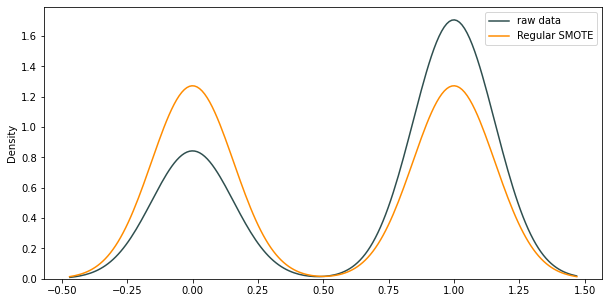

In [20]:
X_resampled_sm, y_resampled_sm = SMOTE().fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_resampled_sm, label="Regular SMOTE",color="darkorange")
plt.legend()
plt.show()

In [21]:
pd.concat([X.describe(),X_resampled_sm.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,-0.164324,-0.184853,-0.142467,-0.073181,0.090848,-0.185607
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,0.951301,0.905298,0.893826,0.926371,0.880203,0.924945
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.996010,-2.411664,-2.047652,-2.196576,-3.597963,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.894015,-0.785246,-0.844532,-0.727685,-0.400889,-0.688220
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,-0.364605,-0.312046,-0.275115,-0.148845,0.105687,-0.558087
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.519698,0.250847,0.364012,0.526272,0.636241,0.111003
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,3.138539,2.635121,5.855771,3.395818,10.460350


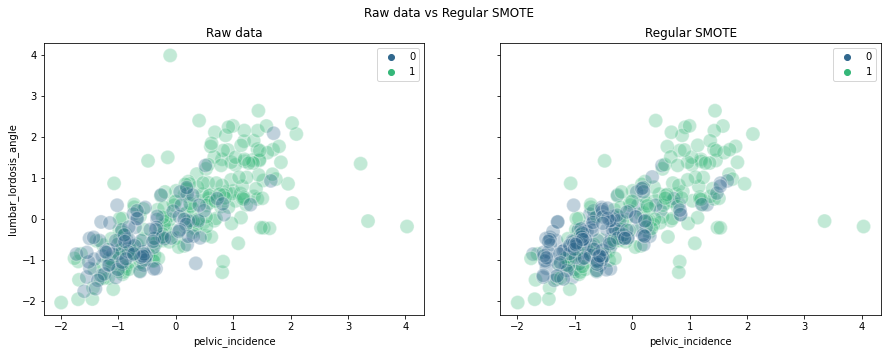

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs Regular SMOTE')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")

# oversampled data
sns.scatterplot(x=X_resampled_sm.pelvic_incidence,y=X_resampled_sm.lumbar_lordosis_angle,hue=y_resampled_sm,palette="viridis",s=200,alpha=.3)
axes[1].set_title("Regular SMOTE")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

Some plot were overlapped again.

#### <a class="anchor" id="7.1.2.1"></a>**7.1.2.1 SMOTE Variants***

#### SMOTENC
* Over-sample using SMOTE for continuous and categorical features.


#### SMOTEN
* Over-sample using the SMOTE variant specifically for categorical features only.


#### BorderlineSMOTE
* Over-sample using the borderline-SMOTE variant.


#### SVMSMOTE
* Over-sample using the SVM-SMOTE variant.


#### ADASYN
* Over-sample using ADASYN.


#### KMeansSMOTE
* Over-sample applying a clustering before to oversample using SMOTE.



![varr](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_007.png)

## *It can be tedious to try them all on a notebook like this, I'll try some features.*

### <a class="anchor" id="7.1.3"></a>**7.1.3 ADASYN *(Adaptive Synthetic)***
[Back to Index](#22)

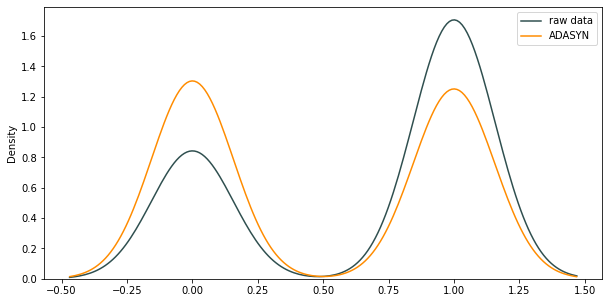

In [23]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_resampled_adasyn, label="ADASYN",color="darkorange")
plt.legend()
plt.show()

In [24]:
pd.concat([X.describe(),X_resampled_adasyn.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,-0.138427,-0.119066,-0.139708,-0.088977,0.064619,-0.176247
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,0.936981,0.861761,0.906765,0.938662,0.874213,0.911235
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.996010,-2.411664,-2.047652,-2.196576,-3.597963,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.851997,-0.722732,-0.852812,-0.760462,-0.426411,-0.674350
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,-0.324093,-0.214229,-0.266835,-0.175544,0.080518,-0.539628
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.535020,0.271094,0.448387,0.554381,0.548091,0.108482
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,3.138539,2.635121,5.855771,3.395818,10.460350


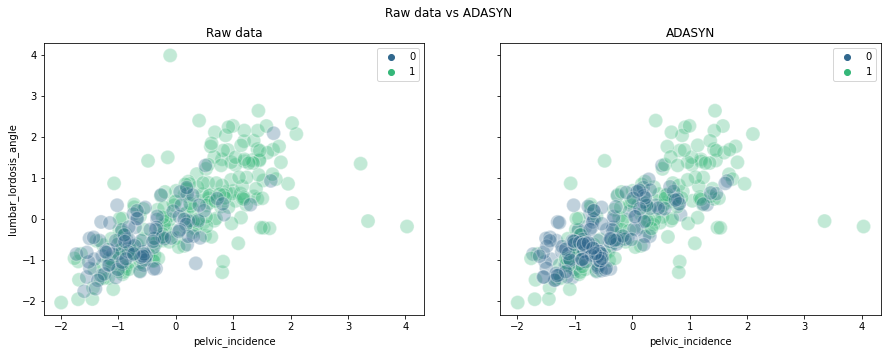

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs ADASYN')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")

# ADASYN
sns.scatterplot(x=X_resampled_adasyn.pelvic_incidence,y=X_resampled_adasyn.lumbar_lordosis_angle,hue=y_resampled_adasyn,palette="viridis",s=200,alpha=.3)
axes[1].set_title("ADASYN")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

## <a class="anchor" id="7.2"></a>**7.2 Under Sampling Methods**
[Back to Index](#22)

### <a class="anchor" id="7.2.1"></a>**7.2.1 Random Under Sampler with Tomek links Method**

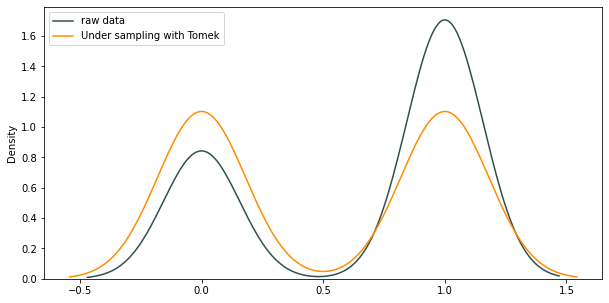

In [26]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)

X_under_res, y_under_res = rus.fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_under_res, label="Under sampling with Tomek",color="darkorange")
plt.legend()
plt.show()

In [27]:
pd.concat([X.describe(),X_under_res.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,-0.173157,-0.207090,-0.159843,-0.067942,0.122730,-0.202143
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,0.954935,0.884240,0.915295,0.982045,0.792635,1.058274
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.763452,-2.411664,-1.961798,-1.991848,-1.797690,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.888399,-0.786694,-0.860035,-0.739920,-0.400889,-0.695956
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,-0.381944,-0.322968,-0.266512,-0.159653,0.093527,-0.554796
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.520611,0.270264,0.349928,0.545993,0.645797,0.042024
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,2.440996,2.265255,5.855771,2.551106,10.460350


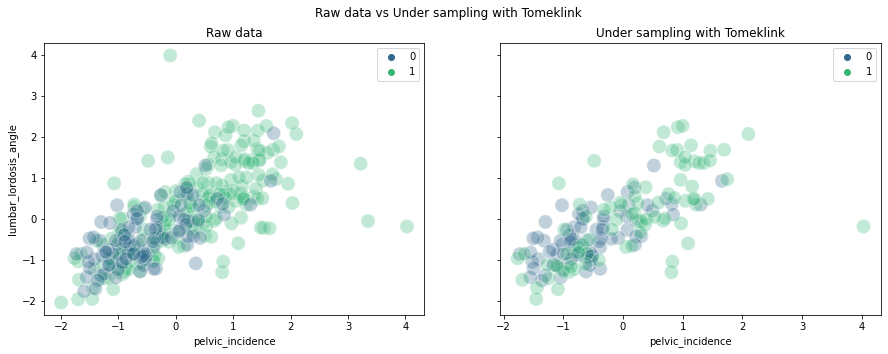

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs Under sampling with Tomeklink')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")

# ADASYN
sns.scatterplot(x=X_under_res.pelvic_incidence,y=X_under_res.lumbar_lordosis_angle,hue=y_under_res,palette="viridis",s=200,alpha=.3)
axes[1].set_title("Under sampling with Tomeklink")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

### <a class="anchor" id="7.2.2"></a>**7.2.2 Edited Nearest Neighbours**
[Back to Index](#22)

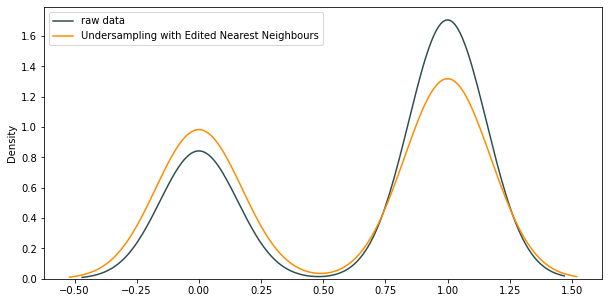

In [29]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_enn, label="Undersampling with Edited Nearest Neighbours",color="darkorange")
plt.legend()
plt.show()

In [30]:
pd.concat([X.describe(),X_enn.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,0.100713,-0.036801,0.103985,0.156765,-0.035865,0.078459
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.017921,1.026895,0.976760,0.993805,0.975494,1.120501
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.763452,-2.340713,-1.961798,-1.907770,-3.597963,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.717860,-0.771194,-0.636907,-0.591308,-0.598552,-0.652214
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,0.066309,-0.226717,-0.015210,0.084539,0.018925,-0.333108
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.862160,0.445826,0.664777,0.837275,0.585569,0.698956
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,3.138539,2.635121,5.855771,2.551106,10.460350


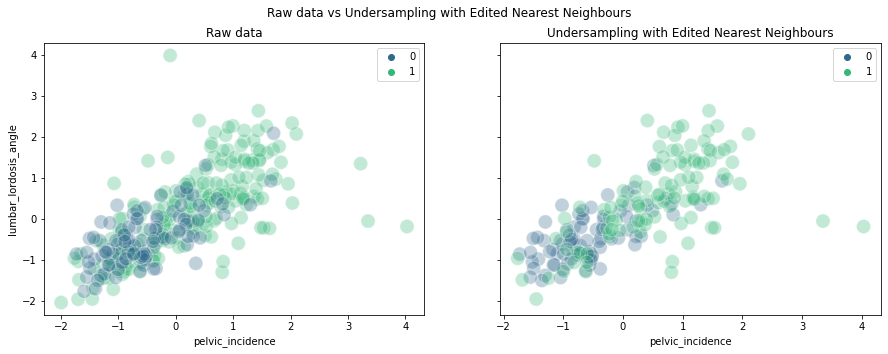

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs Undersampling with Edited Nearest Neighbours')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")

# ADASYN
sns.scatterplot(x=X_enn.pelvic_incidence,y=X_enn.lumbar_lordosis_angle,hue=y_enn,palette="viridis",s=200,alpha=.3)
axes[1].set_title("Undersampling with Edited Nearest Neighbours")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

## <a class="anchor" id="7.3"></a>**7.3 Combined Re-sampling method**
[Back to Index](#22)

### <a class="anchor" id="7.3.1"></a>**7.3.1 SMOTE Tomek**

Introduced first by Batista et al. (2003), this method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class (that is, samples of data from the majority class that is closest with the minority class data). The process of SMOTE-Tomek Links is as follows:


* 1. (Start of SMOTE) Choose random data from the minority class.
* 2. Calculate the distance between the random data and its k nearest neighbors.
* 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
* 4. Repeat step number 2–3 until the desired proportion of minority class is met. (End of SMOTE)
* 5. (Start of Tomek Links) Choose random data from the majority class.
* 6. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.


[Reference](https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc)

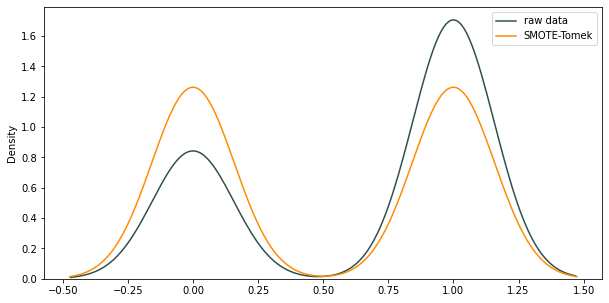

In [32]:
smtomek = SMOTETomek(random_state=42)
X_resampled_smt, y_resampled_smt = smtomek.fit_resample(X_train, y_train)
plt.figure(figsize=(10,5))
sns.kdeplot(y_train,label="raw data",color="darkslategray")
sns.kdeplot(y_resampled_smt, label="SMOTE-Tomek",color="darkorange")
plt.legend()
plt.show()

In [33]:
pd.concat([X.describe(),X_resampled_smt.describe()],axis=1)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,3.100000e+02,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,-9.168293e-17,1.833659e-16,1.375244e-16,-1.031433e-16,4.354939e-16,1.833659e-16,-0.153763,-0.173620,-0.135817,-0.067995,0.114862,-0.169890
std,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,1.001617e+00,0.941106,0.866870,0.894907,0.930569,0.900181,0.936310
min,-1.996010e+00,-2.411664e+00,-2.047652e+00,-2.207741e+00,-3.597963e+00,-9.961725e-01,-1.996010,-2.131943,-2.047652,-2.196576,-3.597963,-0.996172
25%,-8.173982e-01,-6.881138e-01,-8.060267e-01,-7.168418e-01,-5.423830e-01,-6.585073e-01,-0.859623,-0.780671,-0.823825,-0.734435,-0.353806,-0.678668
50%,-1.049246e-01,-1.186061e-01,-1.278621e-01,-4.095971e-02,2.613767e-02,-3.874502e-01,-0.375432,-0.312264,-0.266190,-0.132744,0.115226,-0.548017
75%,7.194643e-01,4.581158e-01,5.975493e-01,7.269414e-01,5.676209e-01,3.997679e-01,0.532772,0.207338,0.359206,0.568572,0.654795,0.142101
max,4.029206e+00,3.191402e+00,3.984615e+00,5.855771e+00,3.395818e+00,1.046035e+01,4.029206,3.138539,2.635121,5.855771,3.395818,10.460350


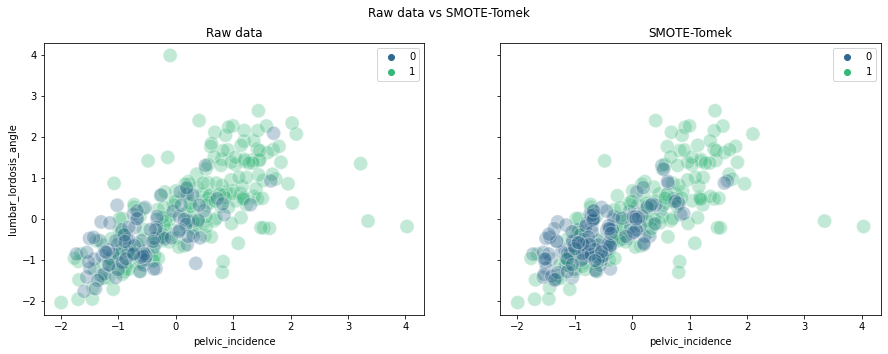

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Raw data vs SMOTE-Tomek')

# Raw data
sns.scatterplot(ax=axes[0],x=X.pelvic_incidence,y=X.lumbar_lordosis_angle,hue=y,palette="viridis",s=200,alpha=.3)
axes[0].set_title("Raw data")

# SMOTE-Tomek
sns.scatterplot(x=X_resampled_smt.pelvic_incidence,y=X_resampled_smt.lumbar_lordosis_angle,hue=y_resampled_smt,palette="viridis",s=200,alpha=.3)
axes[1].set_title("SMOTE-Tomek")
#In the figure below, we compare the decision functions of a classifier trained using the over-sampled data set and the original data set.
plt.show()

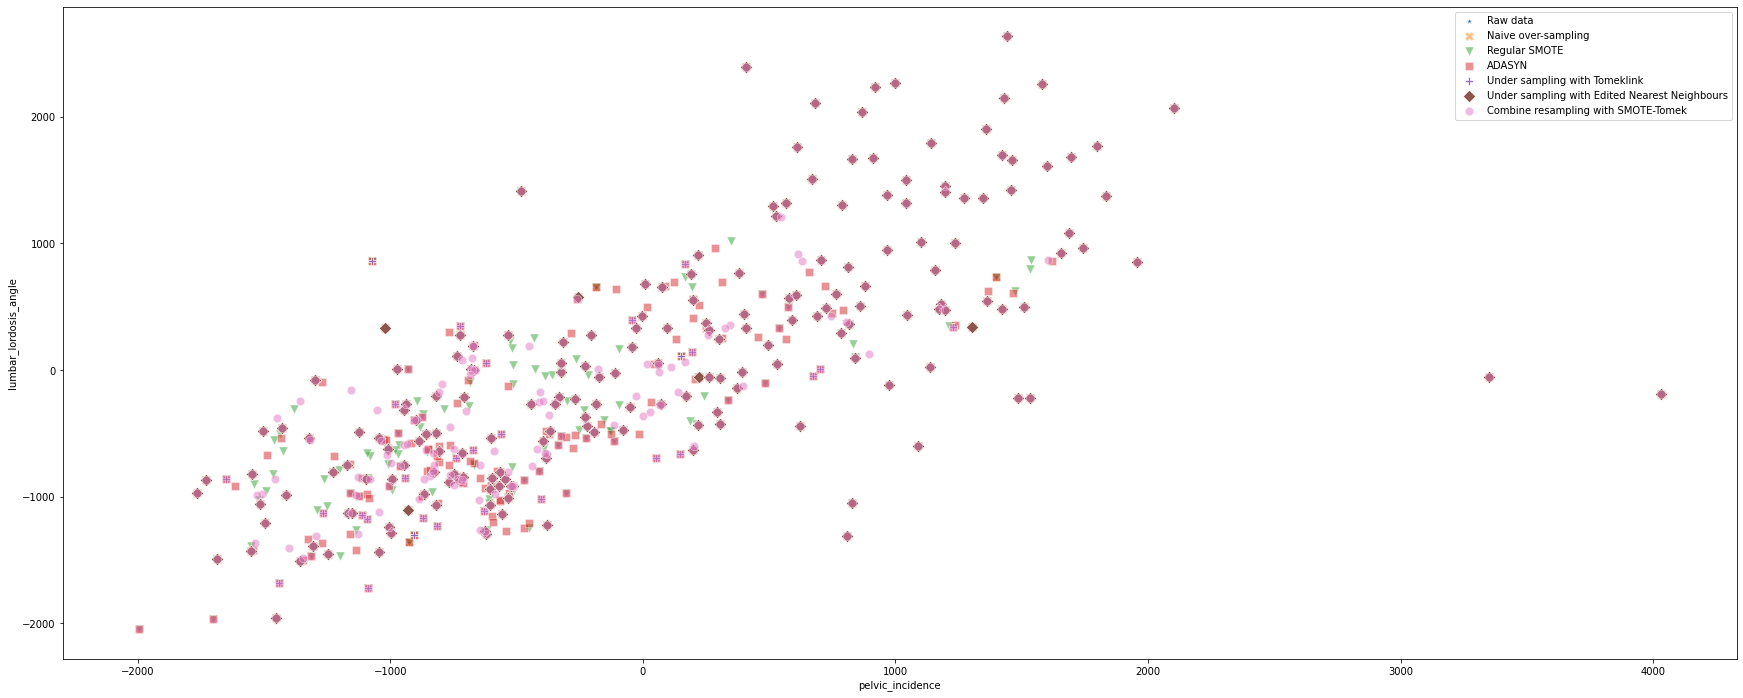

In [35]:
# Comparing one feature across all datasets

dataset_list_X = [X_train,X_resampled_naive,X_resampled_sm,X_resampled_adasyn,X_under_res,X_enn,X_resampled_smt]
dataset_list_y = [y_train,y_resampled_naive,y_resampled_sm,y_resampled_adasyn,y_under_res,y_enn,y_resampled_smt]

plt.figure(figsize=(30,12))
sns.scatterplot(x=dataset_list_X[0].pelvic_incidence*1000,y=dataset_list_X[0].lumbar_lordosis_angle*1000,alpha=1,s=40,label="Raw data",marker="*")
sns.scatterplot(x=dataset_list_X[1].pelvic_incidence*1000,y=dataset_list_X[1].lumbar_lordosis_angle*1000,alpha=.5,s=80,label="Naive over-sampling",marker="X")
sns.scatterplot(x=dataset_list_X[2].pelvic_incidence*1000,y=dataset_list_X[2].lumbar_lordosis_angle*1000,alpha=.5,s=80,label="Regular SMOTE",marker="v")
sns.scatterplot(x=dataset_list_X[3].pelvic_incidence*1000,y=dataset_list_X[3].lumbar_lordosis_angle*1000,alpha=.5,s=80,label="ADASYN",marker="s")
sns.scatterplot(x=dataset_list_X[4].pelvic_incidence*1000,y=dataset_list_X[4].lumbar_lordosis_angle*1000,alpha=1,s=80,label="Under sampling with Tomeklink",marker="P")
sns.scatterplot(x=dataset_list_X[5].pelvic_incidence*1000,y=dataset_list_X[5].lumbar_lordosis_angle*1000,alpha=1,s=80,label="Under sampling with Edited Nearest Neighbours",marker="D")
sns.scatterplot(x=dataset_list_X[6].pelvic_incidence*1000,y=dataset_list_X[6].lumbar_lordosis_angle*1000,alpha=.5,s=80,label="Combine resampling with SMOTE-Tomek",marker="8")
plt.show()


* In general, those with oversampling did not create outlier data and created more data in the center of the data cluster.
* Undersampling methods never generate new unique values.

# <a class="anchor" id="8"></a>**8. Model Building and Evaluation**
[Back to Index](#22)

### <a class="anchor" id="8.1"></a>**8.1 Hyper optimisation with Randomised Search Algorithm**


* RandomizedSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

* The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

* In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

* If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.



In [36]:
#Import libraries
import numpy as np
from scipy.stats import randint
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

cbc = CatBoostClassifier()

# Creating the hyperparameter grid
param_dist = {"learning_rate": np.linspace(0,0.2,5),
              "max_depth" : randint(3, 10),
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='accuracy', cv =5,verbose=False)

#Fit the model
#rscv.fit(dataset_list_X[6],dataset_list_y[6])

# Print the tuned parameters and score
#print(rscv.best_params_)
#print(rscv.best_score_)

### Results

In [37]:
randomized_paramter_search_results ={"Raw Dataset":{"parameters": {'iterations': 50, 'learning_rate': 0.15000000000000002, 'max_depth': 9}, "cv score": 0.854},
                                    "Naive Over sampling":{"parameters": {'iterations': 100, 'learning_rate': 0.2, 'max_depth': 8}, "cv score": 0.879},
                                    "SMOTE":{"parameters": {'iterations': 90, 'learning_rate': 0.05, 'max_depth': 8}, "cv score": 0.885},
                                    "ADASYN":{"parameters": {'iterations': 100, 'learning_rate': 0.2, 'max_depth': 5}, "cv score":0.887},
                                    "Under sampling with Tomek link":{"parameters": {'iterations': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 5}, "cv score": 0.835},
                                    "Edited Nearest Neighbours":{"parameters": {'iterations': 70, 'learning_rate': 0.15000000000000002, 'max_depth': 6}, "cv score": 0.963},
                                    "SMOTE-Tomek":{"parameters": {'iterations': 40, 'learning_rate': 0.2, 'max_depth': 7}, "cv score": 0.887}}


randomized_paramter_search_result_df = pd.DataFrame(data=randomized_paramter_search_results,columns=["Raw Dataset","Naive Over sampling","SMOTE","ADASYN","Under sampling with Tomek link","Edited Nearest Neighbours","SMOTE-Tomek"],
                                                   index=["parameters","cv score"])
randomized_paramter_search_result_df.reset_index(inplace=True)
randomized_paramter_search_result_df

,index,Raw Dataset,Naive Over sampling,SMOTE,ADASYN,Under sampling with Tomek link,Edited Nearest Neighbours,SMOTE-Tomek
0,parameters,"{'iterations': 50, 'learning_rate': 0.15000000...","{'iterations': 100, 'learning_rate': 0.2, 'max...","{'iterations': 90, 'learning_rate': 0.05, 'max...","{'iterations': 100, 'learning_rate': 0.2, 'max...","{'iterations': 100, 'learning_rate': 0.1500000...","{'iterations': 70, 'learning_rate': 0.15000000...","{'iterations': 40, 'learning_rate': 0.2, 'max_..."
1,cv score,0.854,0.879,0.885,0.887,0.835,0.963,0.887


### <a class="anchor" id="8.2"></a>**8.2 Hyper optimisation based Grid Search with OPTUNA**


### Optuna
Optuna is the SOTA algorithm for fine-tuning ML and deep learning models. It depends on the Bayesian fine-tuning technique. It prunes unpromising trials which don’t further improve our score and try only that combination that improves our score overall.


[Back to Index](#22)

In [38]:
!pip install optuna

In [39]:
parameters_came_from_list = ['Raw Dataset', 'Naive Over sampling', 'SMOTE', 'ADASYN',
       'Under sampling with Tomek link', 'Edited Nearest Neighbours',
       'SMOTE-Tomek']

ts_acc_result = []
ts_roc_auc_result = []

for i in range(0,7):
    model = CatBoostClassifier(**randomized_paramter_search_result_df[parameters_came_from_list[i]].iloc[0])
    model.fit(dataset_list_X[i],dataset_list_y[i],verbose=100)
    y_pred=model.predict(X_test)
    ts_acc_result.append(accuracy_score(y_test,y_pred))
    ts_roc_auc_result.append(roc_auc_score(y_test, y_pred))

0:	learn: 0.6486186	total: 61.7ms	remaining: 3.02s
49:	learn: 0.1733755	total: 416ms	remaining: 0us
0:	learn: 0.6293422	total: 6.21ms	remaining: 615ms
99:	learn: 0.0603116	total: 421ms	remaining: 0us
0:	learn: 0.6744030	total: 6.6ms	remaining: 587ms
89:	learn: 0.2212978	total: 383ms	remaining: 0us
0:	learn: 0.6206511	total: 923us	remaining: 91.4ms
99:	learn: 0.1260793	total: 89.5ms	remaining: 0us
0:	learn: 0.6472686	total: 758us	remaining: 75.1ms
99:	learn: 0.1261396	total: 60ms	remaining: 0us
0:	learn: 0.6259448	total: 1.4ms	remaining: 96.8ms
69:	learn: 0.0537023	total: 75.8ms	remaining: 0us
0:	learn: 0.6199084	total: 3.16ms	remaining: 123ms
39:	learn: 0.1493671	total: 106ms	remaining: 0us


In [40]:
randomized_paramter_search_results ={"Raw Dataset":{"parameters": {'iterations': 50, 'learning_rate': 0.15000000000000002, 'max_depth': 9}, "cv score": 0.854,"test accuracy score":0.804,"test ROC-AUC score":0.838},
                                    "Naive Over sampling":{"parameters": {'iterations': 100, 'learning_rate': 0.2, 'max_depth': 8}, "cv score": 0.879,"test accuracy score":0.820,"test ROC-AUC score":0.838},
                                    "SMOTE":{"parameters": {'iterations': 90, 'learning_rate': 0.05, 'max_depth': 8}, "cv score": 0.885,"test accuracy score":0.881,"test ROC-AUC score":0.854},
                                    "ADASYN":{"parameters": {'iterations': 100, 'learning_rate': 0.2, 'max_depth': 5}, "cv score":0.887,"test accuracy score":0.797,"test ROC-AUC score":0.806},
                                    "Under sampling with Tomek link":{"parameters": {'iterations': 100, 'learning_rate': 0.15000000000000002, 'max_depth': 5}, "cv score": 0.835,"test accuracy score":0.881,"test ROC-AUC score":0.854},
                                    "Edited Nearest Neighbours":{"parameters": {'iterations': 70, 'learning_rate': 0.15000000000000002, 'max_depth': 6}, "cv score": 0.963,"test accuracy score":0.85,"test ROC-AUC score":0.822},
                                    "SMOTE-Tomek":{"parameters": {'iterations': 40, 'learning_rate': 0.2, 'max_depth': 7}, "cv score": 0.887,"test accuracy score":0.78,"test ROC-AUC score":0.806}}


randomized_paramter_search_result_df = pd.DataFrame(data=randomized_paramter_search_results,columns=["Raw Dataset","Naive Over sampling","SMOTE","ADASYN","Under sampling with Tomek link","Edited Nearest Neighbours","SMOTE-Tomek"],
                                                   index=["parameters","cv score","test accuracy score","test ROC-AUC score"])
randomized_paramter_search_result_df.reset_index(inplace=True)
randomized_paramter_search_result_df

,index,Raw Dataset,Naive Over sampling,SMOTE,ADASYN,Under sampling with Tomek link,Edited Nearest Neighbours,SMOTE-Tomek
0,parameters,"{'iterations': 50, 'learning_rate': 0.15000000...","{'iterations': 100, 'learning_rate': 0.2, 'max...","{'iterations': 90, 'learning_rate': 0.05, 'max...","{'iterations': 100, 'learning_rate': 0.2, 'max...","{'iterations': 100, 'learning_rate': 0.1500000...","{'iterations': 70, 'learning_rate': 0.15000000...","{'iterations': 40, 'learning_rate': 0.2, 'max_..."
1,cv score,0.854,0.879,0.885,0.887,0.835,0.963,0.887
2,test accuracy score,0.804,0.82,0.881,0.797,0.881,0.85,0.78
3,test ROC-AUC score,0.838,0.838,0.854,0.806,0.854,0.822,0.806


### <a class="anchor" id="8.2.1"></a>**8.2.1 Raw data with optimised paramters**
[Back to Index](#22)

In [41]:
import catboost as cb
import optuna
from sklearn.preprocessing import StandardScaler

# Re-import data and re-procces all data

data = pd.read_csv("../input/biomechanical-features-of-orthopedic-patients/column_2C_weka.csv")
data["class"] = [1 if each == "Abnormal" else 0 for each in data["class"]]
y = data["class"].values 
X = data.drop(["class"],axis=1) 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
columns_df = X.columns
scaled_X = pd.DataFrame(data_scaled, columns = columns_df)
X = scaled_X


smtomek = SMOTETomek(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size = 0.2,random_state=42)
smote_X, smote_y = smtomek.fit_resample(X_train, y_train)
smote_X.shape,smote_y.shape


#for optimization code referance:  https://www.kaggle.com/code/saurabhshahane/catboost-hyperparameter-tuning-with-optuna/notebook

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 2, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
            'od_type': 'Iter',
            'od_wait': 40,
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=40)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [42]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=500, timeout=60)

In [43]:
#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
 #   print("    {}: {}".format(key, value))

In [44]:
#params = trial.params
params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.06240272734359074,
 'depth': 4,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.46984035201519636}

In [45]:
#params = trial.params

X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size = 0.2,random_state=42)

model = cb.CatBoostClassifier(**params)
model.fit(X_train,y_train,verbose=100)

y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



y_pred_tr = model.predict(X_train)
y_pred_ts = model.predict(X_test)

# Accuracy'yi yazdır

print('Train Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_tr)))
print('Train ROC AUC score: {0:0.2f}'.format(roc_auc_score(y_train, y_pred_tr)))
print('Test Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred_ts)))
print('Test ROC-AUC score: {0:0.3f}'.format(roc_auc_score(y_test, y_pred_ts)))

0:	learn: 0.6896199	total: 2.46ms	remaining: 2.45s
100:	learn: 0.5054013	total: 94.8ms	remaining: 844ms
200:	learn: 0.4290915	total: 177ms	remaining: 705ms
300:	learn: 0.3874503	total: 262ms	remaining: 609ms
400:	learn: 0.3544838	total: 348ms	remaining: 520ms
500:	learn: 0.3286840	total: 467ms	remaining: 465ms
600:	learn: 0.3132274	total: 624ms	remaining: 414ms
700:	learn: 0.2934966	total: 837ms	remaining: 357ms
800:	learn: 0.2814823	total: 1000ms	remaining: 248ms
900:	learn: 0.2722262	total: 1.24s	remaining: 137ms
999:	learn: 0.2625769	total: 1.43s	remaining: 0us
[[12  6]
 [ 7 37]]
0.7903225806451613
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.86      0.84      0.85        44

    accuracy                           0.79        62
   macro avg       0.75      0.75      0.75        62
weighted avg       0.79      0.79      0.79        62

Train Accuracy score: 0.89
Train ROC AUC score: 0.88
Test Accura

### <a class="anchor" id="8.2.2"></a>**Balanced data set with SMOTE-Tomek**
[Back to Index](#22)

In [46]:


#for optimization code referance:  https://www.kaggle.com/code/saurabhshahane/catboost-hyperparameter-tuning-with-optuna/notebook

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(smote_X,smote_y, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 2, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
            'od_type': 'Iter',
            'od_wait': 40,
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=40)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [47]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=500, timeout=60)

In [48]:
#print("Number of finished trials: {}".format(len(study.trials)))
#
#print("Best trial:")
#trial = study.best_trial
#
#print("  Value: {}".format(trial.value))
#
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [49]:
params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.07840953623984635,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 6.253745627106128}



#params = trial.params
X_train, X_test, y_train, y_test = smote_X,scaled_X,smote_y,y
model = cb.CatBoostClassifier(**params)
model.fit(X_train,y_train,verbose=100)

y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



y_pred_tr = model.predict(X_train)
y_pred_ts = model.predict(X_test)

# Accuracy'yi yazdır

print('Train Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_tr)))
print('Train ROC AUC score: {0:0.2f}'.format(roc_auc_score(y_train, y_pred_tr)))
print('Test Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred_ts)))
print('Test ROC-AUC score: {0:0.3f}'.format(roc_auc_score(y_test, y_pred_ts)))

0:	learn: 0.6898966	total: 247us	remaining: 247ms
100:	learn: 0.4951639	total: 14.4ms	remaining: 128ms
200:	learn: 0.4133391	total: 29ms	remaining: 115ms
300:	learn: 0.3612716	total: 42.5ms	remaining: 98.6ms
400:	learn: 0.3285802	total: 57.4ms	remaining: 85.7ms
500:	learn: 0.3030277	total: 71.6ms	remaining: 71.3ms
600:	learn: 0.2802978	total: 86ms	remaining: 57.1ms
700:	learn: 0.2600019	total: 101ms	remaining: 43.1ms
800:	learn: 0.2413575	total: 116ms	remaining: 28.8ms
900:	learn: 0.2283462	total: 130ms	remaining: 14.2ms
999:	learn: 0.2210920	total: 143ms	remaining: 0us
[[ 90  10]
 [ 25 185]]
0.8870967741935484
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       100
           1       0.95      0.88      0.91       210

    accuracy                           0.89       310
   macro avg       0.87      0.89      0.88       310
weighted avg       0.90      0.89      0.89       310

Train Accuracy score: 0.92
Train ROC AUC score: 0.92
T

### Others balanced dataset with Optuna Grid Search

In [50]:
datas_for_grid_X = (dataset_list_X[1],dataset_list_X[2],dataset_list_X[3],dataset_list_X[4],dataset_list_X[5])
datas_for_grid_y = (dataset_list_y[1],dataset_list_y[2],dataset_list_y[3],dataset_list_y[4],dataset_list_y[5])

naive_parameter = {'objective': 'Logloss', 'colsample_bylevel': 0.08623327955933364, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9969632934883285}
smote_paramter = {'objective': 'Logloss',  'colsample_bylevel': 0.041950725700119276,  'depth': 6,  'boosting_type': 'Ordered',  'bootstrap_type': 'Bernoulli',  'subsample': 0.30472501338023517}
adasyn_parameter = {'objective': 'Logloss',  'colsample_bylevel': 0.08086391984617815,  'depth': 4,  'boosting_type': 'Plain',  'bootstrap_type': 'Bernoulli',  'subsample': 0.9871954405936965}
und_tomek = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.05248924942376702,  'depth': 3,  'boosting_type': 'Plain',  'bootstrap_type': 'MVS'}
enn = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.09611553542936932,  'depth': 5,  'boosting_type': 'Plain',  'bootstrap_type': 'MVS'}

parameter_list = (naive_parameter,smote_paramter,adasyn_parameter,und_tomek,enn)

tr_acc = []
tr_roc_auc = []
ts_acc = []
ts_roc_auc = []

for i in range(len(parameter_list)):
    X_train, X_test, y_train, y_test = datas_for_grid_X[i],scaled_X,datas_for_grid_y[i],y
    model_other = cb.CatBoostClassifier(**parameter_list[i])
    model_other.fit(X_train,y_train,verbose=False)
    y_pred_tr = model_other.predict(X_train)
    y_pred_ts = model_other.predict(X_test)
    tr_acc.append(accuracy_score(y_train, y_pred_tr))
    tr_roc_auc.append(roc_auc_score(y_train, y_pred_tr))
    ts_acc.append(accuracy_score(y_test, y_pred_ts))
    ts_roc_auc.append(roc_auc_score(y_test, y_pred_ts))

    
# My purpose with this kernel isn't comparing re-sampling methods. Please look conclusion section for all result. 

### **Please check conclusion section**
[Go to Conclusion](#15)

### I can see more clearly that, in finding to best hyper parameters the Grid Search algorithm is better than the Randomized Search algorithm for this dataset. Therefore, after this part, I will improve the model performance with feature selection.

# <a class="anchor" id="9"></a>**9. Feautere importance explaining with SHAP library**
[Back to Index](#22)

In [51]:
!pip install shap
import shap
shap.initjs()

# SHAP (SHapley Additive exPlanations)

I have read this subject from many places, but I could not find an article that is as clear as this. While there is such a beautiful article, I will not try to explain it. I left a reference for a more detailed explanation and you can click on the [link](https://medium.com/@dataman-ai) for other works of the author.


Is your highly-trained model easy to understand? A sophisticated machine learning algorithm usually can produce accurate predictions, but its notorious “black box” nature does not help adoption at all. Think about this: If you ask me to swallow a black pill without telling me what’s in it, I certainly don’t want to swallow it. The interpretability of a model is like a label on a drug bottle. We need to make our effective pill transparent for easy adoption.


SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2017) is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley values. How can we do that? The SHAP value is a great tool among others like LIME (see my post “Explain Your Model with LIME”), InterpretML (see my post “Explain Your Model with Microsoft’s InterpretML”), or ELI5. The SHAP value also is an important tool in Explainable AI or Trusted AI, an emerging development in AI (see my post “An Explanation for eXplainable AI”). 


### What is the Shapley Value?

Let me explain the Shapley value with a story: Assume Ann, Bob, and Cindy together were hammering an “error” wood log, 38 inches, to the ground. After work, they went to a local bar for a drink and I, a mathematician, came to join them. I asked a very bizarre question: “What is everyone’s contribution (in inches)?”

![shap](https://miro.medium.com/max/700/1*SDxC8yBZK1AkEAawlYlt3Q.jpeg)




[Referance](https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d)

How to answer this question? I listed all the permutations and came up with the data in Table A.(Some of you already asked me how to come up with this table. See my note at the end of the article.) When the ordering is A, B, C, the marginal contributions of the three are 2, 32, and 4 inches respectively.

![table A](https://miro.medium.com/max/419/1*9tT9mSTcXEL_YhHmu2t6Ow.png)

Table (A) shows the coalition of (A,B) or (B,A) is 34 inches, so the marginal contribution of C to this coalition is 4 inches. I took the average of all the permutations for each person to get each individual’s contribution: Ann is 2 inches, Bob is 32 inches and Cindy is 4 inches. That’s the way to calculate the Shapley value: It is the average of the marginal contributions across all permutations. I will describe the calculation in the formal mathematical term at the end of this post. But now, let’s see how it is applied in machine learning.



I called the wood log the “error” log for a special reason: It is the loss function in the context of machine learning. The “error” is the difference between the actual value and prediction. The hammers are the predictors to attack the error log. How do we measure the contributions of the hammers (predictors)? The Shapley values!



### From the Shapley Value to SHAP (SHapley Additive exPlanations)



The SHAP (SHapley Additive exPlanations) deserves its own space rather than an extension of the Shapley value. Inspired by several methods (1,2,3,4,5,6,7) on model interpretability, Lundberg and Lee (2016) proposed the SHAP value as a united approach to explaining the output of any machine learning model. Three benefits worth mentioning here.



The first one is global interpretability — the collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target (see the SHAP value plot below).
The second benefit is local interpretability — each observation gets its own set of SHAP values (see the individual SHAP value plot below). This greatly increases its transparency. We can explain why a case receives its prediction and the contributions of the predictors. Traditional variable importance algorithms only show the results across the entire population but not on each individual case. The local interpretability enables us to pinpoint and contrast the impacts of the factors.


Third, the SHAP values can be calculated for any tree-based model, while other methods use linear regression or logistic regression models as the surrogate models.
Model Interpretability Does Not Mean Causality



It is important to point out the SHAP values do not provide causality. In the “identify causality” series of articles, I demonstrate econometric techniques that identify causality. Those articles cover the following techniques: Regression Discontinuity (see “Identify Causality by Regression Discontinuity”), Difference in differences (DiD)(see “Identify Causality by Difference in Differences”), Fixed-effects Models (See “Identify Causality by Fixed-Effects Models”), and Randomized Controlled Trial with Factorial Design (see “Design of Experiments for Your Change Management”).

### Data Visualization and Model Explainability



Data visualization and model explainability are two integral aspects in a data science project. They are the binoculars helping you to see the patterns in the data and the stories in your model. I have written a series of articles on data visualization, including “Pandas-Bokeh to Make Stunning Interactive Plots Easy”, “Use Seaborn to Do Beautiful Plots Easy”, “Powerful Plots with Plotly” and “Create Beautiful Geomaps with Plotly”. Or you can bookmark the summary post “Dataman Learning Paths — Build Your Skills, Drive Your Career” that lists the links to all articles. My goal in the data visualization articles is to assist you to produce data visualization exhibits and insights easily and proficiently. Also, I choose the same data for both the data visualization and model explainability in all these articles so you can see how the two go hand in hand. If you would like to adopt all these data visualization codes or make your work more proficient, take a look of them.

![rsl](https://miro.medium.com/max/700/1*PgVZVZJMFsZ4qwRiml5igA.png)




# Open the Black Box!
### Feature importance

[Reference](https://christophm.github.io/interpretable-ml-book/shap.html#definition)

In [52]:
model.fit(smote_X, smote_y, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(smote_X)

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, smote_X)

#### Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. One cluster stands out: On the right is a group with a high predicted abnormal patient.


* You can cluster your data with the help of Shapley values. The goal of clustering is to find groups of similar instances. Normally, clustering is based on features. Features are often on different scales. For example, height might be measured in meters, color intensity from 0 to 100 and some sensor output between -1 and 1. The difficulty is to compute distances between instances with such different, non-comparable features.

* SHAP clustering works by clustering the Shapley values of each instance. This means that you cluster instances by explanation similarity. All SHAP values have the same unit – the unit of the prediction space. You can use any clustering method. The following example uses hierarchical agglomerative clustering to order the instances.

* The plot consists of many force plots, each of which explains the prediction of an instance. We rotate the force plots vertically and place them side by side according to their clustering similarity.

In [54]:
# Higher Risk

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[66,:], smote_X.iloc[66,:])

In [55]:
# Lower Risk

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(smote_X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[249,:], smote_X.iloc[249,:])

#### SHAP values to explain the predicted disease probabilities of two individuals. The baseline – the average predicted probability – is 0.3397. The first patient has a high predicted risk of 2.56. Risk increasing effects such as degree_spondylolisthesis are offset by decreasing effects such as pelvic_tilt numeric variable. The second patient has a low predicted risk of -1.28. Patient's degree_sponylolisthesis and sacral_slope decrease patient's predicted according to abnormal class.

##### These were explanations for individual predictions.

Shapley values can be combined into global explanations. If we run SHAP for every instance, we get a matrix of Shapley values. This matrix has one row per data instance and one column per feature. We can interpret the entire model by analyzing the Shapley values in this matrix.

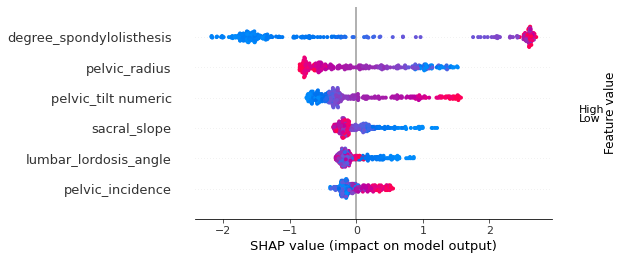

In [56]:
# summarize the effects of all the features
plt.figure(figsize=(12,15))
shap.summary_plot(shap_values, smote_X)
plt.show()

#### SHAP summary plot. Actually right side have red to blue color scale. This bar represents the value of feature low to high. Blue is low and red is high. Low number of degree_spondylolisthesis reduce the predicted abnormal class, a large number of pelvic_tilt numeric increases the risk. Your regular reminder: All effects describe the behavior of the model and are not necessarily causal in the real world.


The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

CatBoost found a near similar result.

In [57]:
import plotly.express as px
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

# <a class="anchor" id="10"></a>**10. Feature Selection with RFECV algorithm**
[Back to Index](#22)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import rfecv
from yellowbrick.datasets import load_credit
SEED  = 42
X_train, X_test, y_train, y_test = smote_X,X_test,smote_y,y_test
def randomforest(X_train,X_test, y_train, y_test):
    parameters = {"max_features": ["auto"],#["auto", "sqrt", "log2"],
                  "min_samples_split": np.arange(2,6),#np.arange(2,16),
                  "min_samples_leaf":np.arange(1,6),#np.arange(1,12),
                  "criterion":["gini"],#["gini","entropy"],
                  "n_estimators":[20],}#[10, 15, 20, 25, 30],}


    model_random_forest = RandomForestClassifier(random_state=SEED,class_weight='balanced',)
    model_random_forest = GridSearchCV(model_random_forest, parameters, cv=5,scoring='accuracy',)
    model_random_forest.fit(X_train, y_train)
    params = model_random_forest.best_params_
    model = RandomForestClassifier(random_state=SEED,class_weight='balanced',**params)
    results = cross_val_score(estimator = model, X = X_train, y= y_train, cv = 5)
    a = np.mean(results)
    b = np.std(results)
    return model_random_forest.best_params_, model_random_forest.best_score_,a,b
#rrf_result = randomforest(X_train,X_test, y_train, y_test)
#rf_params = rrf_result[0]
#print(f'Best score: {rrf_result[1]}')

In [59]:
rf_params = {'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 20}

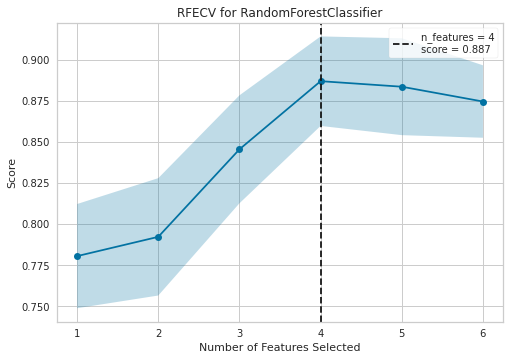

In [60]:
cv = StratifiedKFold(5,random_state=42,shuffle=True)
visualizer = rfecv(RandomForestClassifier(**rf_params), X=smote_X, y=smote_y, cv=cv, scoring='f1_weighted')

### I used RFECV and SHAP algorithms when selecting features. RFECV algorithm found that 5 feature parameters include the most optimum variance for the modeling dataset. Then, we selected the first 5 features with the higher SHAP value and dropped the remaining ones.

# <a class="anchor" id="11"></a>**11. Final Model**
[Back to Index](#22)

In [61]:
dropped_smote_X = smote_X.drop(columns=["lumbar_lordosis_angle"])
dropped_X_test = X_test.drop(columns=["lumbar_lordosis_angle"])
dropped_smote_X.shape,dropped_X_test.shape

((320, 5), (310, 5))

In [62]:
smote_y.shape,y_test.shape

((320,), (310,))

In [63]:
def objective(trial):
    train_x, valid_x, train_y, valid_y =  dropped_smote_X,dropped_X_test,smote_y,y_test

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
            'od_type': 'Iter',
            'od_wait': 40,
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=40)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [64]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=500, timeout=60)
#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [65]:
#params = trial.params
params = {'objective': 'CrossEntropy',
 'colsample_bylevel': 0.09711744706629986,
 'depth': 7,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

In [66]:
#params = trial.params
X_train, X_test, y_train, y_test = dropped_smote_X,dropped_X_test,smote_y,y_test
model = cb.CatBoostClassifier(**params)
model.fit(X_train,y_train,verbose=100)

y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



y_pred_tr = model.predict(X_train)
y_pred_ts = model.predict(X_test)



print('Train Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_tr)))
print('Train ROC AUC score: {0:0.2f}'.format(roc_auc_score(y_train, y_pred_tr)))
print('Test Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred_ts)))
print('Test ROC-AUC score: {0:0.3f}'.format(roc_auc_score(y_test, y_pred_ts)))

0:	learn: 0.6785976	total: 374us	remaining: 374ms
100:	learn: 0.4192787	total: 15.9ms	remaining: 141ms
200:	learn: 0.3297479	total: 32.1ms	remaining: 128ms
300:	learn: 0.2645798	total: 48ms	remaining: 111ms
400:	learn: 0.2322674	total: 63.2ms	remaining: 94.5ms
500:	learn: 0.2091656	total: 79.8ms	remaining: 79.5ms
600:	learn: 0.1999686	total: 92.9ms	remaining: 61.7ms
700:	learn: 0.1798606	total: 109ms	remaining: 46.4ms
800:	learn: 0.1648019	total: 126ms	remaining: 31.2ms
900:	learn: 0.1503092	total: 142ms	remaining: 15.6ms
999:	learn: 0.1437337	total: 157ms	remaining: 0us
[[ 89  11]
 [ 16 194]]
0.9129032258064517
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       100
           1       0.95      0.92      0.93       210

    accuracy                           0.91       310
   macro avg       0.90      0.91      0.90       310
weighted avg       0.91      0.91      0.91       310

Train Accuracy score: 0.96
Train ROC AUC score: 0.96


# <a class="anchor" id="11"></a>**12. Principal Component Analysis**
[Back to Index](#22)

In [67]:
data = pd.read_csv("../input/biomechanical-features-of-orthopedic-patients/column_2C_weka.csv")
data["class"] = [1 if each == "Abnormal" else 0 for each in data["class"]]
y = data["class"].values 
X = data.drop(["class"],axis=1) 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
columns_df = X.columns
scaled_X = pd.DataFrame(data_scaled, columns = columns_df)
X = scaled_X


smtomek = SMOTETomek(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size = 0.2,random_state=42)
smote_X, smote_y = smtomek.fit_resample(X_train, y_train)
smote_X.shape,smote_y.shape


from sklearn.decomposition import PCA
pca = PCA(n_components = .99)
X_train_pca = pca.fit_transform(smote_X)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((320, 5), (62, 5))

### PCA was protected varriance with five dimension like as RFECV

In [68]:
def objective(trial):
    train_x, valid_x, train_y, valid_y =  X_train_pca,X_test_pca,smote_y,y_test

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
            'od_type': 'Iter',
            'od_wait': 40,
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=40)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=500, timeout=20)
#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [69]:
#params = trial.params


X_train, X_test, y_train, y_test = X_train_pca,X_test_pca,smote_y,y_test
model = cb.CatBoostClassifier(**params)
model.fit(X_train,y_train,verbose=100)

y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))



y_pred_tr = model.predict(X_train)
y_pred_ts = model.predict(X_test)



print('Train Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_tr)))
print('Train ROC AUC score: {0:0.2f}'.format(roc_auc_score(y_train, y_pred_tr)))
print('Test Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred_ts)))
print('Test ROC-AUC score: {0:0.3f}'.format(roc_auc_score(y_test, y_pred_ts)))

0:	learn: 0.6882708	total: 405us	remaining: 405ms
100:	learn: 0.4996089	total: 15.1ms	remaining: 134ms
200:	learn: 0.4081937	total: 31.9ms	remaining: 127ms
300:	learn: 0.3449361	total: 46.7ms	remaining: 108ms
400:	learn: 0.3025660	total: 61.1ms	remaining: 91.3ms
500:	learn: 0.2677210	total: 76.8ms	remaining: 76.5ms
600:	learn: 0.2521789	total: 90.3ms	remaining: 60ms
700:	learn: 0.2319205	total: 104ms	remaining: 44.5ms
800:	learn: 0.2096904	total: 121ms	remaining: 30ms
900:	learn: 0.1956779	total: 135ms	remaining: 14.9ms
999:	learn: 0.1824906	total: 150ms	remaining: 0us
[[13  5]
 [ 6 38]]
0.8225806451612904
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.88      0.86      0.87        44

    accuracy                           0.82        62
   macro avg       0.78      0.79      0.79        62
weighted avg       0.83      0.82      0.82        62

Train Accuracy score: 0.95
Train ROC AUC score: 0.95
Test A

# <a class="anchor" id="13"></a>**13. Model Building with Feature Engineering Data**
[Back to Index](#22)

### Remember that I find one categorical variable.


#### I don't show the code, because this dataset's performance is low than my expectation.
* Raw categorical data, test ROC-AUC score is: 0.71
* With one hot encoding test ROC-AUC score is: 0.82
* Wih ADASYN test ROC-AUC score is: 0.79
* With SMOTE-Tomekl test ROC-AUC score is: 0.82

In [70]:
#result_of_lordosis = []
#for i in range(len(data.lumbar_lordosis_angle)):
#    a = data.lumbar_lordosis_angle[i]
#    if a <= 50 and a>=31:
#        result_of_lordosis.append("normal_lordosis")
#    elif a>70:
#        result_of_lordosis.append("excessive_lordosis")
#    elif a<10:
#        result_of_lordosis.append("lumbar_kyphosis")
#    else:
#        result_of_lordosis.append("hypo_lordosis")
#
#categoric_lordosis_data = data.copy()        
#categoric_lordosis_data["result_of_lordosis"] = result_of_lordosis
#categoric_lordosis_data = categoric_lordosis_data.drop(columns=["lumbar_lordosis_angle"])
#categoric_lordosis_data = categoric_lordosis_data[['pelvic_incidence', 'pelvic_tilt numeric', 
#       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'result_of_lordosis','class']]
#data.lumbar_lordosis_angle.describe() 
#
#
#dropped_feature = categoric_lordosis_data["result_of_lordosis"]
#
#cat_df = categoric_lordosis_data.drop(columns="result_of_lordosis")
#X = cat_df.drop(["class"],axis=1) 
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(X)
#columns_df = X.columns
#cat_df_X = pd.DataFrame(data_scaled, columns = columns_df)
#cat_df_X["lordosis_type"] = dropped_feature

# <a class="anchor" id="14"></a>**14. Result**
[Back to Index](#22)

In [71]:
details = { "Raw dataset" : {"Train data Accuracy score": 0.89,
                             "Train data ROC AUC score": 0.88,
                             "Test data Accuracy score": 0.79,
                             "Test data ROC-AUC score": 0.754},
           "Balanced data by SMOTE Tomek": {"Train data Accuracy score": 0.92,
                                            "Train data ROC AUC score": 0.92,
                                            "Test data Accuracy score": 0.89,
                                            "Test data ROC-AUC score": 0.89},
           "Feature eliminated balanced data by RFECV": {"Train data Accuracy score": 0.96,
                                                         "Train data ROC AUC score": 0.96,
                                                         "Test data Accuracy score": 0.91,
                                                         "Test data ROC-AUC score": 0.91},
          "Raw dataset with categoric feature":{"Train data Accuracy score": 0.92,
                                                "Train data ROC AUC score": 0.91,
                                                "Test data Accuracy score": 0.77,
                                                "Test data ROC-AUC score": 0.71},
           "Naive Over sampling": {"Train data Accuracy score": 0.86,
                                   "Train data ROC AUC score": 0.86,
                                   "Test data Accuracy score": 0.83,
                                   "Test data ROC-AUC score": 0.86},
           "Regular SMOTE": {"Train data Accuracy score": 0.83,
                             "Train data ROC AUC score": 0.83,
                             "Test data Accuracy score": 0.79,
                             "Test data ROC-AUC score": 0.81},
           "ADASYN": {"Train data Accuracy score": 0.84,
                      "Train data ROC AUC score": 0.84,
                      "Test data Accuracy score": 0.80,
                      "Test data ROC-AUC score": 0.84},
           "Under sampling with Tomek link": {"Train data Accuracy score": 0.89,
                                              "Train data ROC AUC score": 0.92,
                                              "Test data Accuracy score": 0.87,
                                              "Test data ROC-AUC score": 0.88},
           "Edited Nearest Neighbours" : {"Train data Accuracy score": 1,
                                          "Train data ROC AUC score": 1,
                                          "Test data Accuracy score": 0.85,
                                          "Test data ROC-AUC score": 0.89},
           "Principal Component Analysis" : {"Train data Accuracy score": .88,
                                          "Train data ROC AUC score": .88,
                                          "Test data Accuracy score": 0.81,
                                          "Test data ROC-AUC score": 0.76}}
           
           


conclusion = pd.DataFrame(data=details,columns=['Raw dataset', 'Balanced data by SMOTE Tomek', 'Feature eliminated balanced data by RFECV',"Raw dataset with categoric feature", 
                                                "Naive Over sampling","Regular SMOTE","ADASYN","Under sampling with Tomek link","Edited Nearest Neighbours","Principal Component Analysis"],
                          
                          index=["Train data Accuracy score","Train data ROC AUC score","Test data Accuracy score","Test data ROC-AUC score"])
           


conclusion.reset_index(inplace=True)
conclusion.rename(columns=({"index":"Metrics"}),inplace=True)
conclusion



,Metrics,Raw dataset,Balanced data by SMOTE Tomek,Feature eliminated balanced data by RFECV,Raw dataset with categoric feature,Naive Over sampling,Regular SMOTE,ADASYN,Under sampling with Tomek link,Edited Nearest Neighbours,Principal Component Analysis
0,Train data Accuracy score,0.890,0.92,0.96,0.92,0.86,0.83,0.84,0.89,1.00,0.88
1,Train data ROC AUC score,0.880,0.92,0.96,0.91,0.86,0.83,0.84,0.92,1.00,0.88
2,Test data Accuracy score,0.790,0.89,0.91,0.77,0.83,0.79,0.80,0.87,0.85,0.81
3,Test data ROC-AUC score,0.754,0.89,0.91,0.71,0.86,0.81,0.84,0.88,0.89,0.76


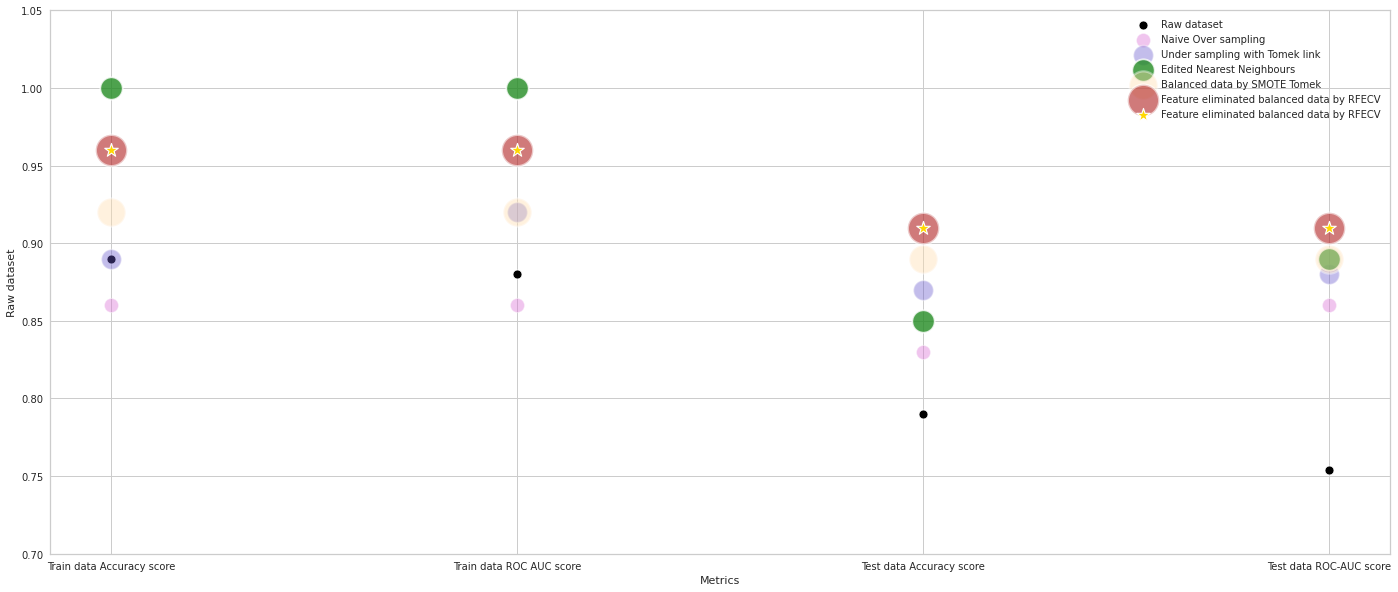

In [72]:
import seaborn as sns

# I selected the upper than 85% scores. --> 'Balanced data by SMOTE Tomek'89, 'Feature eliminated balanced data by RFECV'91, "Naive Over sampling"86,"Under sampling with Tomek link"88,"Edited Nearest Neighbours89"

plt.figure(figsize=(24,10))
#0.75
sns.scatterplot(x=conclusion.Metrics,y=conclusion["Raw dataset"],
                color="black",s=80,alpha=1,label="Raw dataset")
#0.86
sns.scatterplot(x=conclusion.Metrics,y=conclusion["Naive Over sampling"],
                color="orchid",s=200,alpha=.4,label="Naive Over sampling")
#0.88
sns.scatterplot(x=conclusion.Metrics,y=conclusion["Under sampling with Tomek link"],
                color="slateblue",s=400,alpha=.4,label="Under sampling with Tomek link")
#0.89
sns.scatterplot(x=conclusion.Metrics,y=conclusion["Edited Nearest Neighbours"],
                color="forestgreen",s=500,alpha=.8,label="Edited Nearest Neighbours")

sns.scatterplot(x=conclusion.Metrics,y=conclusion["Balanced data by SMOTE Tomek"],
                color="navajowhite",s=800,alpha=.4,label="Balanced data by SMOTE Tomek")
#0.91

sns.scatterplot(x=conclusion.Metrics,y=conclusion["Feature eliminated balanced data by RFECV"],
                color="firebrick",s=1000,alpha=.6,label="Feature eliminated balanced data by RFECV")

sns.scatterplot(x=conclusion.Metrics,y=conclusion["Feature eliminated balanced data by RFECV"],
                color="gold",s=200,alpha=1,label="Feature eliminated balanced data by RFECV",marker="*")



plt.ylim(ymax = 1.05, ymin = 0.70)
plt.legend()
plt.show()

# <a class="anchor" id="15"></a>**15. ROC Analysis**


[Back to Index](#22)

Cannot restore border parameter, falling to default border = 0.5
Cannot restore border parameter, falling to default border = 0.5
Cannot restore border parameter, falling to default border = 0.5
Cannot restore border parameter, falling to default border = 0.5
Cannot restore border parameter, falling to default border = 0.5


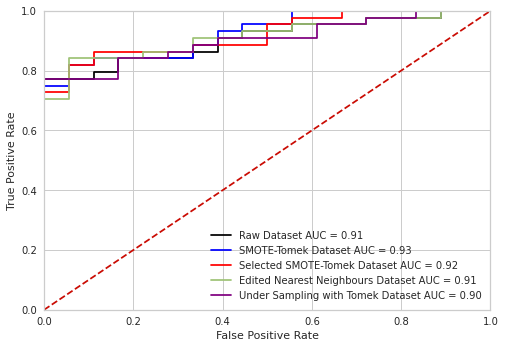

In [73]:
#Prepairing for ROC_AUC Score
from catboost import Pool
from catboost.utils import get_roc_curve
data = pd.read_csv("../input/biomechanical-features-of-orthopedic-patients/column_2C_weka.csv")
data["class"] = [1 if each == "Abnormal" else 0 for each in data["class"]]
y = data["class"].values 
X = data.drop(["class"],axis=1) 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
columns_df = X.columns
scaled_X = pd.DataFrame(data_scaled, columns = columns_df)
X = scaled_X

smtomek = SMOTETomek(random_state=42)
X_train, X_test_raw, y_train, y_test_raw = train_test_split(scaled_X,y,test_size = 0.2,random_state=42)
smote_X, smote_y = smtomek.fit_resample(X_train, y_train)
smote_X.shape,smote_y.shape

# Raw_model
raw_params = params = {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06240272734359074, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.46984035201519636}
model_raw = cb.CatBoostClassifier(**raw_params)
catboost_pool_raw = Pool(X_test_raw,y_test_raw)
model_raw.fit(X_train,y_train, verbose=False)
# Non-selected SMOTE
smote_params = params = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.07840953623984635,  'depth': 7,  'boosting_type': 'Plain',  'bootstrap_type': 'Bayesian',  'bagging_temperature': 6.253745627106128} 
model_smote = cb.CatBoostClassifier(**smote_params)
catboost_pool_smote = Pool(X_test_raw,y_test_raw)
model_smote.fit(smote_X,smote_y, verbose=False)
# Selected SMOTE
dropped_smote_X = smote_X.drop(columns=["lumbar_lordosis_angle"])
dropped_X_test = X_test_raw.drop(columns=["lumbar_lordosis_angle"])
selected_smote_params = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.09711744706629986,  'depth': 7,  'boosting_type': 'Plain',  'bootstrap_type': 'MVS'}
model_selected_smote = cb.CatBoostClassifier(**selected_smote_params)
catboost_pool_selected_smote = Pool(dropped_X_test,y_test_raw)
model_selected_smote.fit(dropped_smote_X,smote_y, verbose=False)
# ENN
enn_params = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.09611553542936932,  'depth': 5,  'boosting_type': 'Plain',  'bootstrap_type': 'MVS'}
model_enn = cb.CatBoostClassifier(**enn_params)
catboost_pool_enn = Pool(X_test_raw,y_test_raw)
model_enn.fit(X_enn, y_enn, verbose=False)
#tomek
under_tomek_params = {'objective': 'CrossEntropy',  'colsample_bylevel': 0.05248924942376702,  'depth': 3,  'boosting_type': 'Plain',  'bootstrap_type': 'MVS'}
model_tomek = cb.CatBoostClassifier(**under_tomek_params)
catboost_pool_tomek = Pool(X_test_raw,y_test_raw)
model_tomek.fit(X_under_res, y_under_res, verbose=False)


(fpr_raw, tpr_raw, thresholds) = get_roc_curve(model_raw, catboost_pool_raw, plot=False)
(fpr_smote, tpr_smote, thresholds) = get_roc_curve(model_smote, catboost_pool_smote, plot=False)
(fpr_selected_smote, tpr_selected_smote, thresholds) = get_roc_curve(model_selected_smote, catboost_pool_selected_smote, plot=False)
(fpr_enn, tpr_enn, thresholds) = get_roc_curve(model_enn, catboost_pool_enn, plot=False)
(fpr_tomek, tpr_tomek, thresholds) = get_roc_curve(model_tomek, catboost_pool_tomek, plot=False)

import sklearn.metrics as metrics

roc_auc_raw = metrics.auc(fpr_raw, tpr_raw)
roc_auc_smote = metrics.auc(fpr_smote, tpr_smote)
roc_auc_selected_smote = metrics.auc(fpr_selected_smote, tpr_selected_smote)
roc_auc_enn = metrics.auc(fpr_enn, tpr_enn)
roc_auc_tomek = metrics.auc(fpr_tomek, tpr_tomek)
plt.plot(fpr_raw, tpr_raw, 'b', label = f'Raw Dataset AUC = {roc_auc_raw:.2f}',color="black")
plt.plot(fpr_smote, tpr_smote, 'b', label = f'SMOTE-Tomek Dataset AUC = {roc_auc_smote:.2f}',color="blue")
plt.plot(fpr_selected_smote, tpr_selected_smote, 'b', label = f'Selected SMOTE-Tomek Dataset AUC = {roc_auc_selected_smote:.2f}',color="red")
plt.plot(fpr_enn, tpr_enn, 'b', label = f'Edited Nearest Neighbours Dataset AUC = {roc_auc_enn:.2f}',color="g")
plt.plot(fpr_tomek, tpr_tomek, 'b', label = f'Under Sampling with Tomek Dataset AUC = {roc_auc_tomek:.2f}',color="purple")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# <a class="anchor" id="16"></a>**16. Conclusion**

[Back to reading](#9)


[Back to Index](#22)


### First of all, I used the CatBoost algorithm, which is known to have high performance with imbalanced data, and of course, different results can be found with other algorithms.
1. First of all, raw data was able to reach a performance of 75%
2. Even if I did feature engineering, it didn't actually improve much of a performance boost.
3. Afterwards, since I found the highest performance with SMOTE-Tomek in algorithms that make the data balanced, I continued with the SMOTE-Tomek for the further model developing process.
4. I tried to optimize with the first Randomized-Search, then I found higher performance with Grid-Search and continued with them.
5. This notebook, also became like a SHAP library tutorial, I'm proud of this. But, I just compile these subjects, someone who explained them amazingly (I have already cited in sections).
6. I found the important features in order with SHAP. The similar features can be viewed from the Optuna functions.
7. Then I determined the optimum number of variances with the RFECV algorithm from the yellowbricks library. Random_state parameter doesn't work correctly in this algorithm, it often results in 5 features. 
8. Then, I considered the higher importance value 5 features to be important since according to the PCA analysis, 5 features are selected when 99% variance is preserved.
9. PCA generally has found better results in my previous studies, but couldn't solve it completely, probably due to the synthetic data of the SMOTE algorithm.
10. The performance of the dataset I gave categorically for the CatBoost algorithm was up to 78%, so the numerical features for this dataset have higher performance.
11. On Linkedin, it is said that algorithms such as SMOTE are constantly overfitting. This didn't happen in our case, and under-sampling can result in the loss of very valuable information. Medical data is more valuable than datasets such as signal collection or electronic data collection because patients don't guarantee creating more data. In our models, the other two under-sampling algorithms had the highest performance after SMOTE-Tomek. Maybe we can relate this to SMOTE-Tomek's under-sampling from synthetic data after over-sampling.
12. Finally, SMOTE-Tomek (91% ROC-AUC score), an combine-oversampling method of balancing the target attribute, provided a 21% performance improvement over the raw dataset (78% ROC-AUC score).

# Please criticize me for any places you think are wrong.